<a href="https://colab.research.google.com/github/iamyunaseo/Multi-Label-Sentiment-Analysis-using-LLMs/blob/main/Multi_Label_Sentiment_Analysis_using_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <Font color = 'indianred'>**Sentiment Analysis using Hugging Face Ecosystem** </font>

## <Font color = 'indianred'>**1. Set Environment**

In [ ]:
import sys

# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quitely without showing output
  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq

  basepath = '/content/drive/MyDrive/NLP/Assignments'

else:
  basepath = '/content/drive/MyDrive/NLP/Assignments'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# standard data science librraies for data handling and v isualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random

# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab

# Load data fille
from datasets import load_dataset, DatasetDict
from datasets import Dataset

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from sklearn.metrics import confusion_matrix
from datetime import datetime

# New libraries introduced in this notebook
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import BitsAndBytesConfig

import wandb
import evaluate
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

In [ ]:
# # # Setting up the device for GPU usage

# from torch import cuda
# device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# load the data

base_folder = Path(basepath)
data_folder = base_folder/'datasets/aclImdb'
model_folder = base_folder/'models/imdb/nn'
custom_functions = base_folder/'custom-functions'

In [ ]:
model_folder.mkdir(exist_ok=True, parents = True)

In [ ]:
model_folder

PosixPath('/content/drive/MyDrive/NLP/Assignments/models/imdb/nn')

## <Font color = 'indianred'>**2. Load  data**

In [ ]:
# load the data from hugging face
emotion_data = load_dataset('harpreetmann/train_emotion_spring_2024')

In [ ]:
emotion_data['train'][0:2]

{'text': ['Does anyone know, are both Sims in a dual sim phone both locked to the same network! #worry',
  'A not very young man compiled info on a smiling baby then a mattress created new evil.'],
 'label': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

In [ ]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
#train_data = load_dataset('csv', data_files= str(base_folder/'emotion_detection_train.csv'))
test_data = load_dataset('csv', data_files= str(base_folder/'emotion_detection_test.csv'))

In [ ]:
test_data

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3259
    })
})

In [ ]:
test_data['train'][0]

{'ID': '2018-01559',
 'Tweet': '@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'anger': 'NONE',
 'anticipation': 'NONE',
 'disgust': 'NONE',
 'fear': 'NONE',
 'joy': 'NONE',
 'love': 'NONE',
 'optimism': 'NONE',
 'pessimism': 'NONE',
 'sadness': 'NONE',
 'surprise': 'NONE',
 'trust': 'NONE'}

In [ ]:
# labels = [label for label in test_data['train'].features.keys() if label not in ['ID', 'Tweet']]
# labels

In [ ]:
test_data_text = test_data.remove_columns(['ID', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
test_data_text = test_data_text.rename_column('Tweet', 'text')

In [ ]:
# Initialize counters for each label in train and valid sets
train_label_counts = Counter()
valid_label_counts = Counter()

# Function to update counts
def update_label_counts(dataset, label_counts):
    for label_array in dataset['label']:
        # print(label_array)
        # label_array is expected to be a list of binary values
        for index, label in enumerate(label_array):
            if label == 1:
                label_counts[index] += 1

# Update counts for both datasets
update_label_counts(emotion_data['train'], train_label_counts)
update_label_counts(emotion_data['valid'], valid_label_counts)

print(train_label_counts)

# Display the label distributions
print("Training set label distribution:")
for label, count in train_label_counts.items():
    print(f"Label {labels[label]}: {count}")

print("\nValidation set label distribution:")
for label, count in valid_label_counts.items():
    print(f"Label {labels[label]}: {count}")

Counter({2: 2330, 0: 2306, 4: 2293, 8: 1850, 6: 1818, 3: 1084, 1: 891, 7: 714, 5: 656, 9: 314, 10: 306})
Training set label distribution:
Label fear: 1084
Label pessimism: 714
Label sadness: 1850
Label anger: 2306
Label anticipation: 891
Label joy: 2293
Label optimism: 1818
Label disgust: 2330
Label trust: 306
Label love: 656
Label surprise: 314

Validation set label distribution:
Label joy: 584
Label anger: 553
Label anticipation: 211
Label disgust: 591
Label optimism: 473
Label pessimism: 181
Label sadness: 423
Label fear: 279
Label love: 176
Label surprise: 82
Label trust: 94


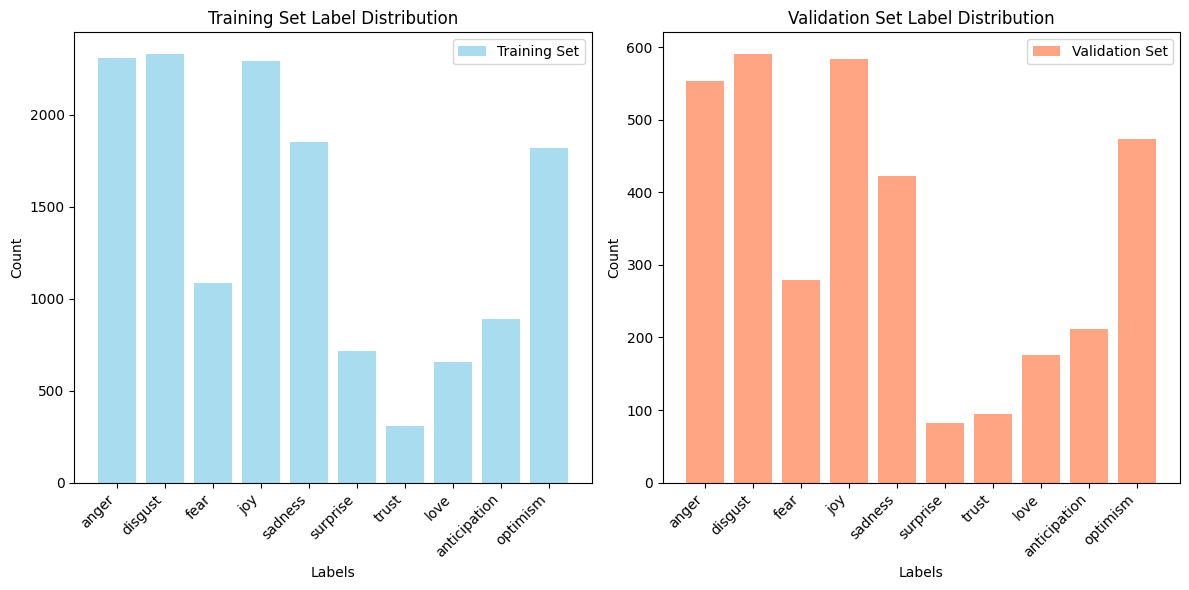

In [ ]:
# Sample data (assuming you have labels)
labels = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'love', 'anticipation', 'optimism']
train_counts = [2306, 2330, 1084, 2293, 1850, 714, 306, 656, 891, 1818]
valid_counts = [553, 591, 279, 584, 423, 82, 94, 176, 211, 473]

x = range(len(labels))  # the label locations

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Training set distribution
ax1.bar(x, train_counts, color='skyblue', alpha=0.7, label='Training Set')
ax1.set_title('Training Set Label Distribution')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_xlabel('Labels')
ax1.set_ylabel('Count')
ax1.legend()

# Validation set distribution
ax2.bar(x, valid_counts, color='coral', alpha=0.7, label='Validation Set')
ax2.set_title('Validation Set Label Distribution')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_xlabel('Labels')
ax2.set_ylabel('Count')
ax2.legend()

# Tight layout
fig.tight_layout()

# Display the plot
plt.show()

# <Font color = 'skyblue'>**Task 1 -part A (LoRA)** </font>

## <Font color = 'indianred'>**1. Load pre-trained Tokenizer** </font>

In [ ]:
# google-gemma
checkpoint = "google/gemma-1.1-2b-it"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [ ]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

In [ ]:
tokenized_test_dataset = test_data_text.map(tokenize_fn, batched=True)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(
    ['text']
)

In [ ]:
tokenized_test_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 3259
    })
})

##  <font color = 'indianred'> **2. Model Training**

###  <font color = 'indianred'> **2.1. compute_metrics function** </font>


In [ ]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

###  <font color = 'indianred'> **2.2. Training Arguments** </font>

In [ ]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_google_gemma"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=False
    # bf16=True
    # tf32= False
)

### <Font color='indianred'> **2.3. Specify Model** <font/>

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification" )


config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config
# model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model = model.to(device)

In [ ]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    

### <Font color='indianred'> **2.4. LoRA Setup** <font/>

In [ ]:
from peft import (
    TaskType,
    LoraConfig,
    get_peft_model,
)

In [ ]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['down_proj',
 'gate_proj',
 'up_proj',
 'q_proj',
 'v_proj',
 'o_proj',
 'score',
 'k_proj']

In [ ]:
gemma_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    target_modules = ['gate_proj', 'k_proj', 'o_proj', 'q_proj', 'score', 'v_proj'])
gemma_model = get_peft_model(model, gemma_config )
gemma_model.print_trainable_parameters()

trainable params: 72,244,608 || all params: 2,578,703,104 || trainable%: 2.8015868863668922


In [ ]:
gemma_config.target_modules

{'gate_proj', 'k_proj', 'o_proj', 'q_proj', 'score', 'v_proj'}

In [ ]:
gemma_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GemmaForSequenceClassification(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
   

### <Font color='indianred'> **2.5. Custom Trainer**<font/>

In [ ]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)


In [ ]:
pos_weights

tensor([ 1.6795,  5.9349,  1.6519,  4.7002,  1.6947,  8.4192,  2.3988,  7.6541,
         2.3400, 18.6783, 19.1928])

In [ ]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # print(inputs)
        # Extract labels and remove them from inputs
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        # print(labels)
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        # Compute custom loss (BCEWithLogitsLoss is suitable for multi-label)
        # pos_weight can be used to handle class imbalance
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        # Reshape labels to match logits dimensions
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
trainer = CustomTrainer(
    model=gemma_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

### <font color='indianred'>**2.6. Setup WanDB**<font/>

In [ ]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_S2024

wandb: Currently logged in as: yuna-seo-95 (yunaseo_). Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=emotions_kaggle_S2024


### <font color = 'indianred'> **2.7. Start Training** <font/>

In [ ]:
trainer.train()  # start training

In [ ]:
trainer.train()  # start training

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.784300,0.633195,0.616397,0.436886,0.130097
40,0.571700,0.557538,0.646761,0.535861,0.179288
60,0.534100,0.529168,0.678791,0.556150,0.200647
80,0.505400,0.514309,0.682958,0.571590,0.204531
100,0.474800,0.503890,0.687492,0.579723,0.175405
120,0.514400,0.502806,0.680445,0.598819,0.163107
140,0.505500,0.510053,0.682299,0.572793,0.203883
160,0.512400,0.485122,0.685370,0.594749,0.179288
180,0.488000,0.490632,0.677747,0.594724,0.163754
200,0.486700,0.496976,0.684465,0.603342,0.222654


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.784300,0.633195,0.616397,0.436886,0.130097
40,0.571700,0.557538,0.646761,0.535861,0.179288
60,0.534100,0.529168,0.678791,0.556150,0.200647
80,0.505400,0.514309,0.682958,0.571590,0.204531
100,0.474800,0.503890,0.687492,0.579723,0.175405
120,0.514400,0.502806,0.680445,0.598819,0.163107
140,0.505500,0.510053,0.682299,0.572793,0.203883
160,0.512400,0.485122,0.685370,0.594749,0.179288
180,0.488000,0.490632,0.677747,0.594724,0.163754
200,0.486700,0.496976,0.684465,0.603342,0.222654


Could not locate the best model at /content/drive/MyDrive/NLP/Assignments/models/emotions_google_gemma/checkpoint-200/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=965, training_loss=0.21707282128111685, metrics={'train_runtime': 16109.1486, 'train_samples_per_second': 1.918, 'train_steps_per_second': 0.06, 'total_flos': 1.4825822189412864e+16, 'train_loss': 0.21707282128111685, 'epoch': 4.99353169469599})

### <font color='indianred'> **2.8. Validation**<font/>

In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.8962887525558472,
 'eval_f1_micro': 0.6927358355929785,
 'eval_f1_macro': 0.5713254343726819,
 'eval_accuracy': 0.2537216828478964,
 'eval_runtime': 85.6221,
 'eval_samples_per_second': 18.044,
 'eval_steps_per_second': 2.266,
 'epoch': 4.99353169469599}

In [ ]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

###  <font color = 'indianred'> **Check Confusion Matrix**</font>

In [ ]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [ ]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

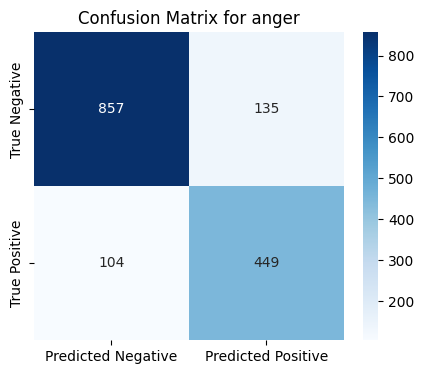

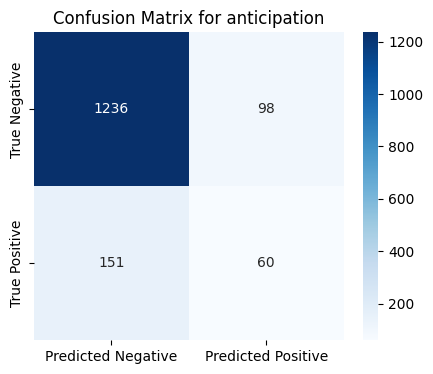

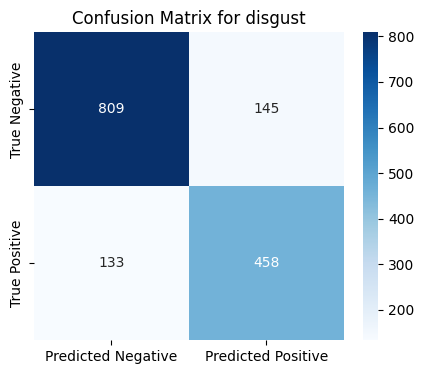

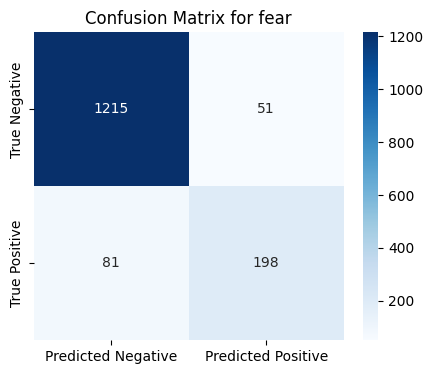

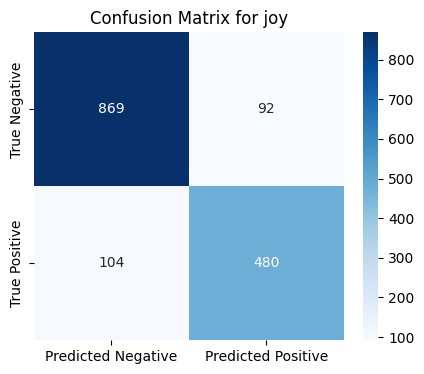

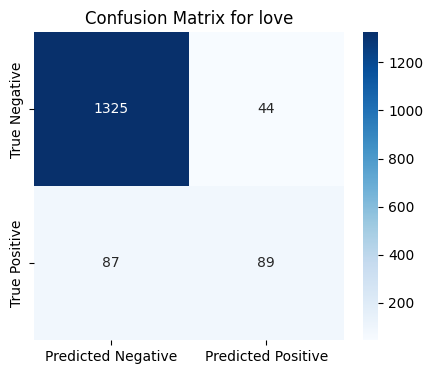

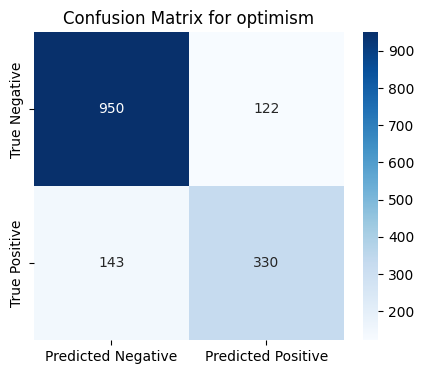

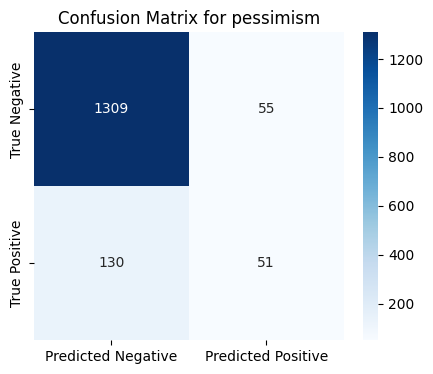

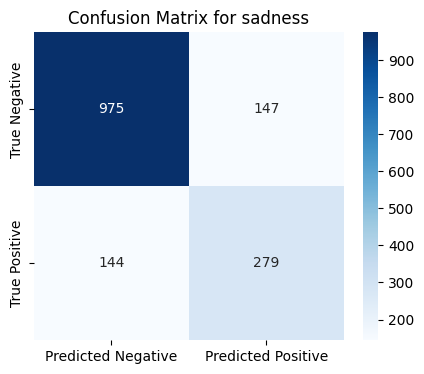

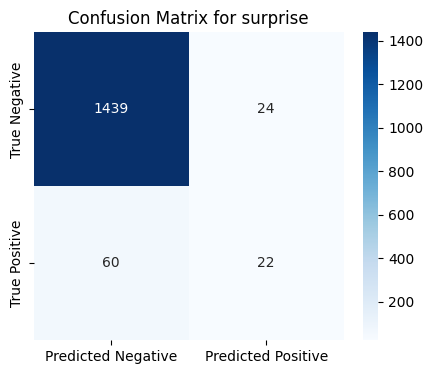

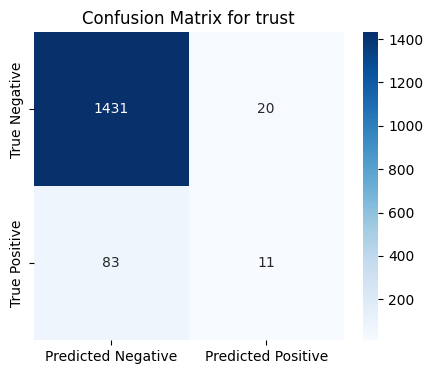

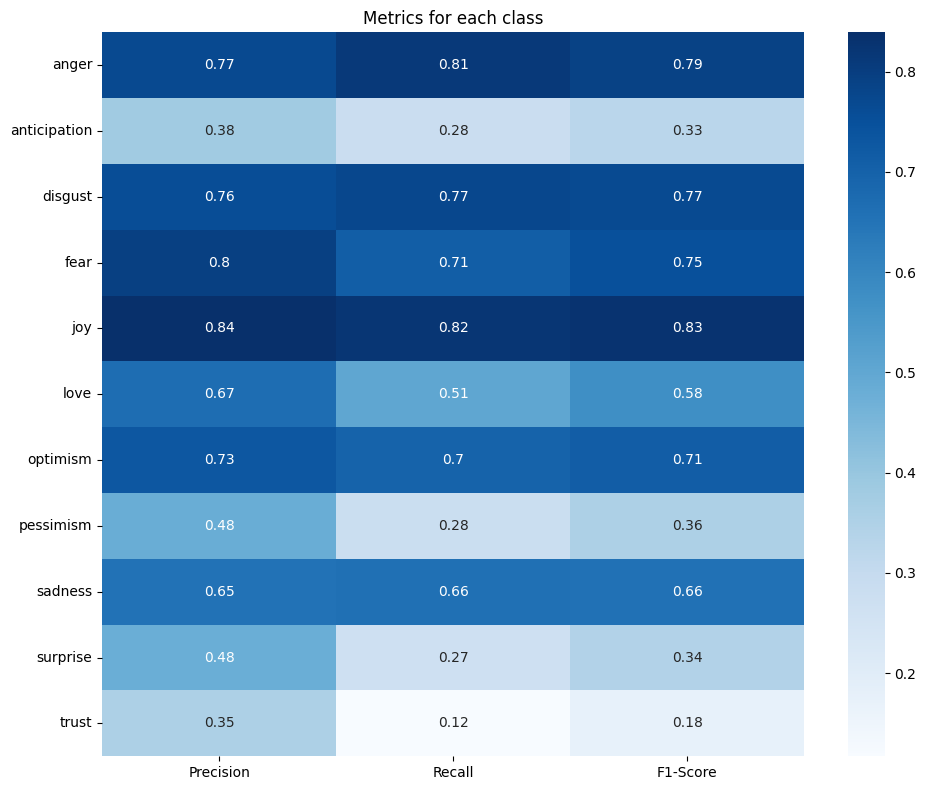

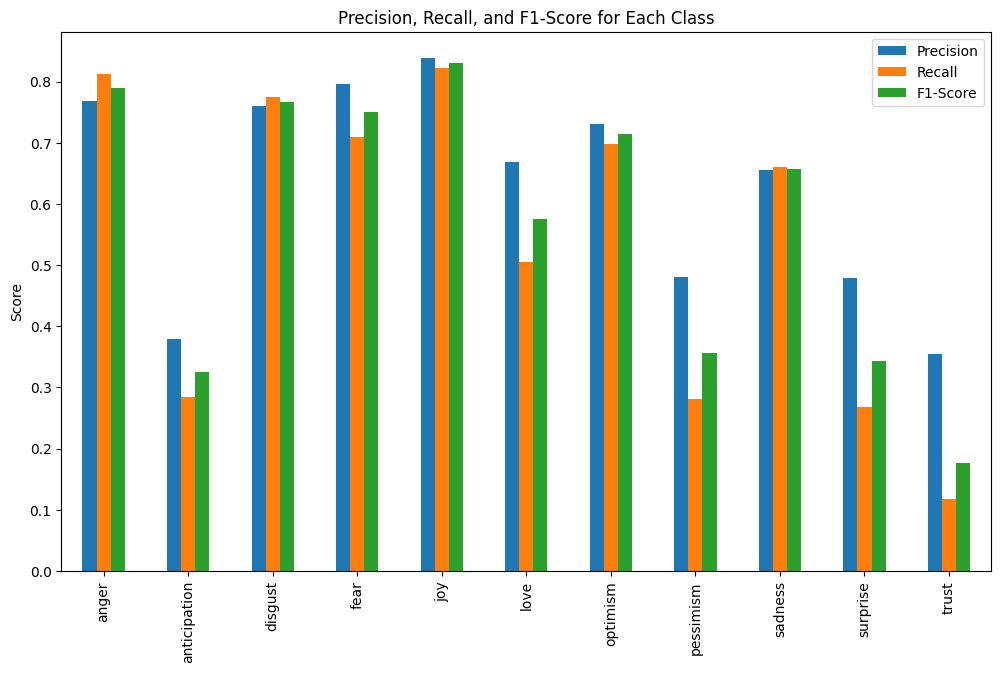

In [ ]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()

In [ ]:
wandb.finish()

eval/accuracy,▁▄▅▅▄▅▄▃▆▅▅▅▄▆▅▅▇▅▅▅▅▆▆▆▇▆▆▆▇▇▇▇██▇██▇██
eval/f1_macro,▁▅▆▇▇▇███▇▇▇█▇█▇▆▇▇▆▇▇▇▇▆▇▆▆▇▇▇▆▆▆▆▆▆▇▇▇
eval/f1_micro,▁▄▇▇█▇▇▇▇▇▆▇▇███▆▇▇▇▇▇▇▇▇▇▇▇███▇██▇█████
eval/loss,▃▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▅▅▄▄▅▅▇▆▇▇▇▇▇▇████████
eval/runtime,▂▃▄▃▃▆▇▇█▄▄▇▃█▅▄▄▃▃▇████▇▄▄▄▅▇█▇▃▃▄██▆▃▁
eval/samples_per_second,▇▆▅▆▅▃▁▁▁▅▄▂▅▁▄▅▅▆▆▂▁▁▁▁▂▅▅▅▄▁▁▂▆▅▅▁▁▃▆█
eval/steps_per_second,▇▆▅▆▅▃▁▁▁▅▄▂▅▁▄▅▅▆▆▂▁▁▁▁▂▅▅▅▄▁▁▂▆▅▅▁▁▃▆█
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁



###  <font color = 'indianred'> **Save the model on HuggingFace**</font>

In [ ]:
trainer.push_to_hub("yunaseo/google_gemma_emotion_detection")

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yunaseo/emotions_google_gemma/commit/d888923418bcdd8b7cb04142738cf73ab8649aba', commit_message='yunaseo/google_gemma_emotion_detection', commit_description='', oid='d888923418bcdd8b7cb04142738cf73ab8649aba', pr_url=None, pr_revision=None, pr_num=None)

## <Font color = 'indianred'>**3. Test Data Prediction** </font>

In [ ]:
# Make predictions
predictions = trainer.predict(tokenized_test_dataset["train"])

In [ ]:
# Post-processing for multi-label classification
threshold = 0.5  # Example threshold
predicted_labels = (predictions.predictions > threshold).astype(int)

# Convert predictions to labels
predicted_labels = [[label for label, binary in zip(labels, binary_labels) if binary] for binary_labels in predicted_labels]

# Print or use the predicted labels
print(predicted_labels)

[['disgust', 'fear', 'optimism'], ['disgust', 'sadness'], ['anger', 'disgust', 'sadness'], ['joy', 'optimism', 'pessimism', 'sadness'], ['fear', 'sadness'], ['anticipation', 'disgust', 'fear'], ['joy', 'optimism'], ['joy'], ['joy', 'optimism'], ['fear', 'sadness'], ['joy', 'optimism'], ['joy', 'optimism'], ['joy', 'love', 'optimism'], ['joy', 'optimism'], ['anger', 'disgust', 'sadness'], ['joy', 'love', 'optimism'], ['optimism'], ['joy', 'optimism'], ['anger', 'disgust'], ['sadness'], ['joy', 'love', 'sadness'], [], ['anticipation'], [], ['joy', 'love'], ['sadness'], ['anger', 'disgust', 'joy', 'optimism'], ['anticipation'], ['anger', 'disgust'], ['anger', 'disgust'], ['joy', 'love', 'optimism', 'sadness'], ['sadness'], ['optimism', 'sadness'], ['anger', 'disgust'], ['anger', 'disgust', 'fear'], ['sadness'], ['disgust', 'joy'], ['anger', 'sadness'], ['anger', 'disgust', 'joy'], ['anger', 'disgust'], ['anger', 'disgust'], ['optimism'], ['anger', 'disgust'], ['anger', 'disgust'], ['sadne

In [ ]:
predicted_labels[0]

['disgust', 'fear', 'optimism']

In [ ]:
test_data

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3259
    })
})

In [ ]:
# Extracting data from the 'train' split of test_data
test_data_train = test_data['train']
tweet_ids = test_data_train['ID']
num_tweets = len(tweet_ids)

In [ ]:
# Initializing an empty dictionary to store the predicted labels
predicted_labels_dict = {category: [0] * num_tweets for category in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']}

# Iterate over each row of predicted labels and update the dictionary
for i, labels in enumerate(predicted_labels):
    for label in labels:
        predicted_labels_dict[label][i] = 1

In [ ]:
# Create DataFrame
df = pd.DataFrame(predicted_labels_dict)

# Insert tweet IDs as the first column
df.insert(0, 'ID', tweet_ids)

In [ ]:
df

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,0,0,1,1,0,0,1,0,0,0,0
1,2018-03739,0,0,1,0,0,0,0,0,1,0,0
2,2018-00385,1,0,1,0,0,0,0,0,1,0,0
3,2018-03001,0,0,0,0,1,0,1,1,1,0,0
4,2018-01988,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,1,0,1,0,0,0,0,0,0,0,0
3255,2018-00416,0,1,0,0,1,0,0,0,0,0,0
3256,2018-03717,1,0,1,0,1,0,0,0,0,0,0
3257,2018-03504,0,0,0,0,1,1,1,0,0,0,0


In [ ]:
df.to_csv('gemma_predicted.csv', index=False)

In [ ]:
from google.colab import files
files.download('gemma_predicted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('gemma_predicted.csv')

# <Font color = 'skyblue'>**Task 1 -part B (QLoRA)** </font>

## <Font color = 'indianred'>**1. Load pre-trained Tokenizer** </font>

In [ ]:
# google-gemma
checkpoint = "google/gemma-1.1-2b-it"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [ ]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

In [ ]:
tokenized_test_dataset = test_data_text.map(tokenize_fn, batched=True)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(
    ['text']
)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
tokenized_test_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 3259
    })
})

##  <font color = 'indianred'> **2. Model Training**

###  <font color = 'indianred'> **2.1. compute_metrics function** </font>


In [ ]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

###  <font color = 'indianred'> **2.2. Training Arguments** </font>

In [ ]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_google_gemma"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=False
    # bf16=True
    # tf32= False
)

### <Font color='indianred'> **2.3. Specify Model** <font/>

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config)

model = prepare_model_for_kbit_training(model)

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config
# model

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config)

model = prepare_model_for_kbit_training(model)

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config
# model

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model = model.to(device)

In [ ]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): Gemma

### <Font color='indianred'> **2.4. LoRA Setup** <font/>

In [ ]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['v_proj',
 'gate_proj',
 'o_proj',
 'score',
 'q_proj',
 'k_proj',
 'down_proj',
 'up_proj']

In [ ]:
gemma_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    #modules_to_save = ['score'],
    target_modules=target_modules)
gemma_model = get_peft_model(model, gemma_config )
gemma_model.print_trainable_parameters()

trainable params: 157,179,264 || all params: 2,663,637,760 || trainable%: 5.900924906545851


In [ ]:
gemma_config.target_modules

{'down_proj',
 'gate_proj',
 'k_proj',
 'o_proj',
 'q_proj',
 'score',
 'up_proj',
 'v_proj'}

In [ ]:
gemma_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GemmaForSequenceClassification(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Lin

### <Font color='indianred'> **2.5. Custom Trainer**<font/>

In [ ]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)


In [ ]:
pos_weights

tensor([ 1.6795,  5.9349,  1.6519,  4.7002,  1.6947,  8.4192,  2.3988,  7.6541,
         2.3400, 18.6783, 19.1928])

In [ ]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # print(inputs)
        # Extract labels and remove them from inputs
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        # print(labels)
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        # Compute custom loss (BCEWithLogitsLoss is suitable for multi-label)
        # pos_weight can be used to handle class imbalance
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        # Reshape labels to match logits dimensions
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
trainer = CustomTrainer(
    model=gemma_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

### <font color='indianred'>**2.6. Setup WanDB**<font/>

In [ ]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_S2024

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=emotions_kaggle_S2024


### <font color = 'indianred'> **2.7. Start Training** <font/>

In [ ]:
trainer.train()  # start training

wandb: Currently logged in as: yuna-seo-95 (yunaseo_). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.730700,0.608064,0.615053,0.471070,0.170874
40,0.527600,0.510603,0.676007,0.572942,0.167638
60,0.508100,0.497804,0.692247,0.585727,0.200647
80,0.509100,0.485264,0.690836,0.603818,0.205178
100,0.482300,0.485842,0.696141,0.606733,0.236893
120,0.334600,0.550028,0.666320,0.572776,0.170227
140,0.324500,0.544026,0.681607,0.581919,0.205178
160,0.337500,0.554108,0.680829,0.585339,0.198706
180,0.340700,0.527467,0.687516,0.587192,0.191586
200,0.274500,0.601874,0.692794,0.578412,0.231068


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=T

TrainOutput(global_step=480, training_loss=0.21830590960259239, metrics={'train_runtime': 8579.8573, 'train_samples_per_second': 3.601, 'train_steps_per_second': 0.056, 'total_flos': 1.642816521712896e+16, 'train_loss': 0.21830590960259239, 'epoch': 4.961240310077519})

In [ ]:
trainer.train()  # start training

wandb: Currently logged in as: yuna-seo-95 (yunaseo_). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.708100,0.604821,0.624417,0.511282,0.152751
40,0.522800,0.509563,0.671284,0.581460,0.188350
60,0.504800,0.492804,0.700225,0.586474,0.215534
80,0.512900,0.479166,0.697035,0.608853,0.210356
100,0.484200,0.480062,0.697194,0.602283,0.236893
120,0.337200,0.554517,0.668655,0.587702,0.176052
140,0.330200,0.537370,0.689522,0.601985,0.201942
160,0.334200,0.532962,0.686048,0.599332,0.211650
180,0.339200,0.519029,0.689382,0.591300,0.200647


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=T

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.708100,0.604821,0.624417,0.511282,0.152751
40,0.522800,0.509563,0.671284,0.581460,0.188350
60,0.504800,0.492804,0.700225,0.586474,0.215534
80,0.512900,0.479166,0.697035,0.608853,0.210356
100,0.484200,0.480062,0.697194,0.602283,0.236893
120,0.337200,0.554517,0.668655,0.587702,0.176052
140,0.330200,0.537370,0.689522,0.601985,0.201942
160,0.334200,0.532962,0.686048,0.599332,0.211650
180,0.339200,0.519029,0.689382,0.591300,0.200647
200,0.284400,0.585347,0.689134,0.581938,0.236893


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=T

TrainOutput(global_step=480, training_loss=0.2224734691902995, metrics={'train_runtime': 8610.0447, 'train_samples_per_second': 3.588, 'train_steps_per_second': 0.056, 'total_flos': 1.642816521712896e+16, 'train_loss': 0.2224734691902995, 'epoch': 4.961240310077519})

### <font color='indianred'> **2.8. Validation**<font/>

In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.48584163188934326,
 'eval_f1_micro': 0.6961412688031393,
 'eval_f1_macro': 0.6067331889083742,
 'eval_accuracy': 0.23689320388349513,
 'eval_runtime': 102.7708,
 'eval_samples_per_second': 15.033,
 'eval_steps_per_second': 0.944,
 'epoch': 4.961240310077519}

In [ ]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

###  <font color = 'indianred'> **Check Confusion Matrix**</font>

In [ ]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [ ]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

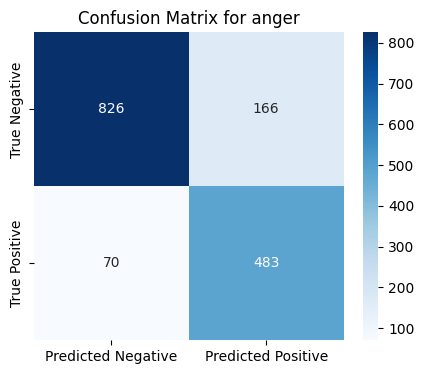

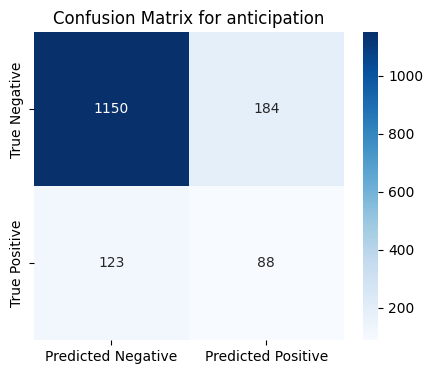

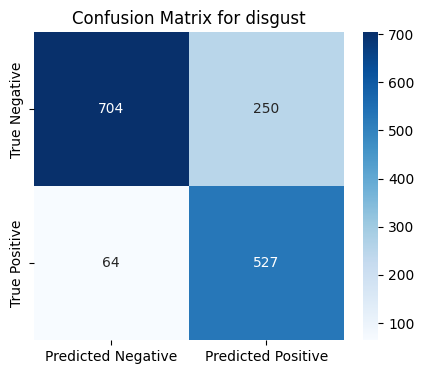

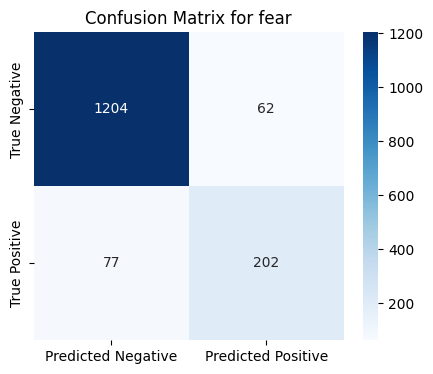

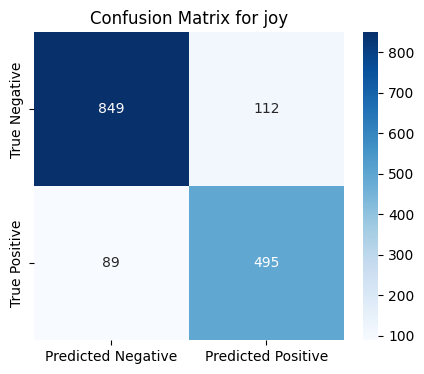

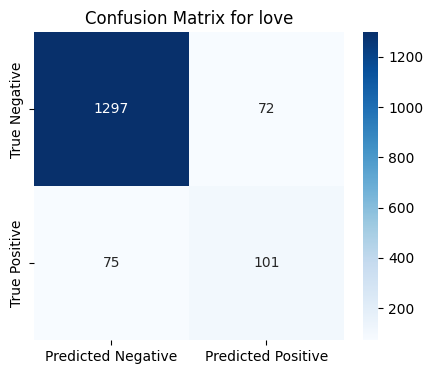

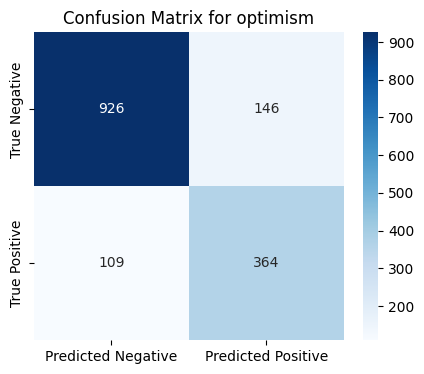

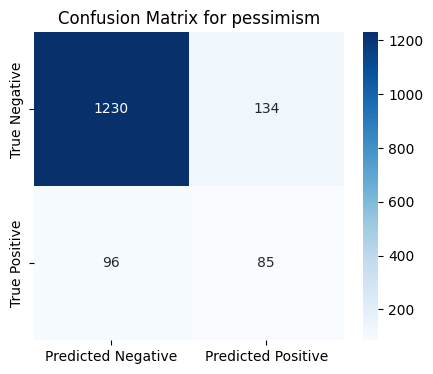

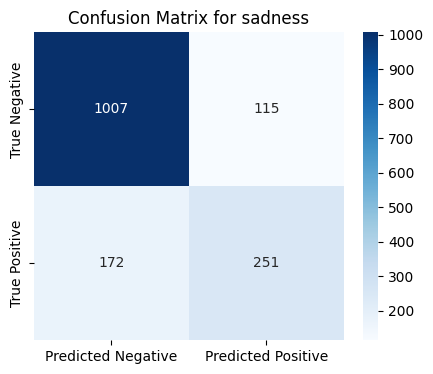

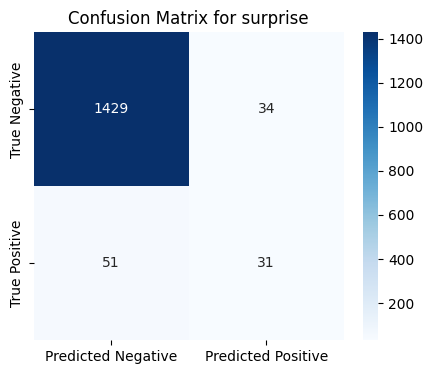

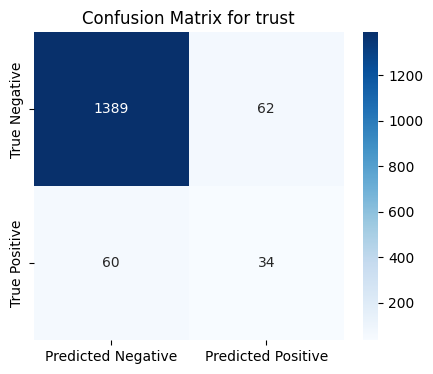

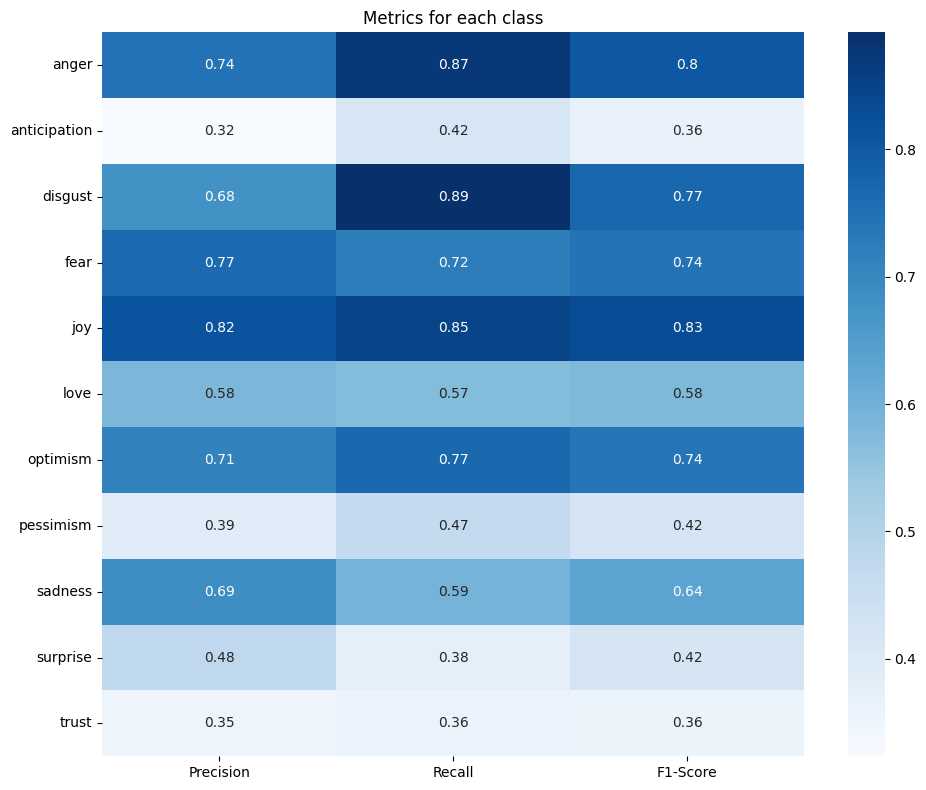

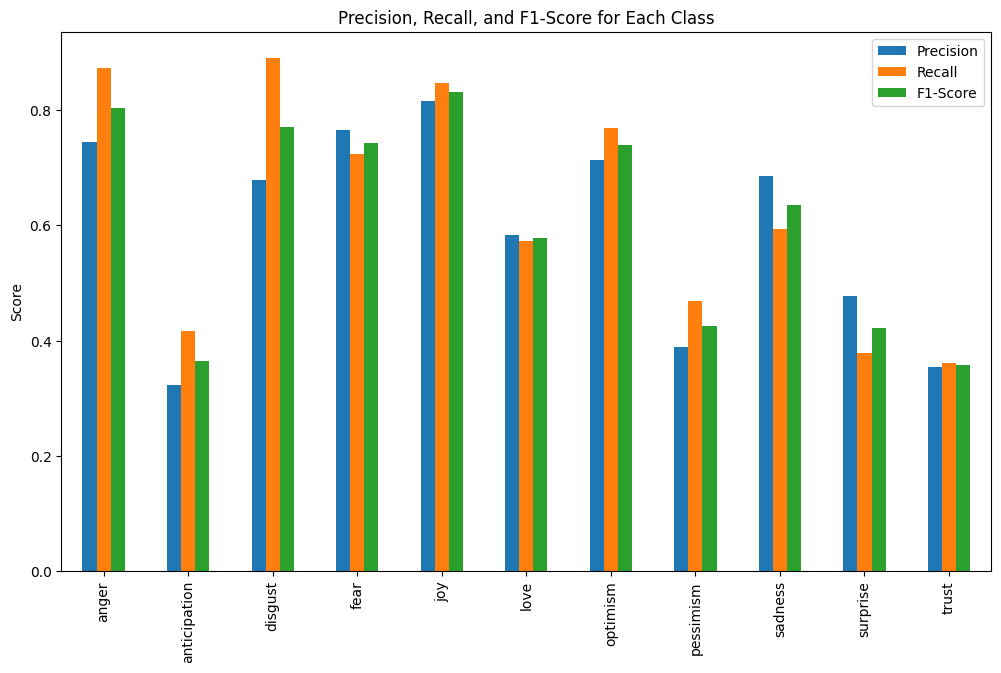

In [ ]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()

In [ ]:
wandb.finish()


###  <font color = 'indianred'> **Save the model on HuggingFace**</font>

In [ ]:
trainer.push_to_hub("yunaseo/google_gemma_qlora_emotion_detection")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/631M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yunaseo/emotions_google_gemma/commit/0eaeba0a4e78184d95515dfca3b5964024345f34', commit_message='yunaseo/google_gemma_qlora_emotion_detection', commit_description='', oid='0eaeba0a4e78184d95515dfca3b5964024345f34', pr_url=None, pr_revision=None, pr_num=None)

## <Font color = 'indianred'>**3. Test Data Prediction** </font>

In [ ]:
# Make predictions
predictions = trainer.predict(tokenized_test_dataset["train"])

In [ ]:
# Post-processing for multi-label classification
threshold = 0.5  # Example threshold
predicted_labels = (predictions.predictions > threshold).astype(int)

# Convert predictions to labels
predicted_labels = [[label for label, binary in zip(labels, binary_labels) if binary] for binary_labels in predicted_labels]

# Print or use the predicted labels
print(predicted_labels)

[['fear'], ['anger', 'disgust', 'sadness'], ['anger', 'disgust', 'sadness'], ['pessimism', 'sadness'], ['fear', 'pessimism', 'sadness'], ['fear'], ['anticipation', 'joy', 'optimism'], ['joy'], ['joy', 'optimism'], ['fear', 'sadness'], ['joy', 'optimism'], ['joy', 'optimism'], ['joy', 'love', 'optimism'], ['joy', 'optimism'], ['disgust', 'sadness'], ['joy', 'optimism'], ['joy', 'optimism', 'trust'], ['joy', 'optimism', 'trust'], ['anger', 'disgust'], ['joy'], ['joy', 'sadness'], ['disgust', 'pessimism'], ['anticipation'], ['disgust'], ['joy', 'love', 'optimism'], ['pessimism', 'sadness'], ['anger', 'disgust', 'joy'], ['disgust'], ['anger', 'disgust'], ['anger', 'disgust'], ['joy', 'love', 'optimism'], ['fear', 'pessimism', 'sadness'], ['fear', 'optimism', 'sadness'], ['anger', 'disgust'], ['anger', 'disgust', 'fear'], ['fear', 'sadness'], ['anger', 'disgust', 'joy'], [], ['anger', 'disgust'], ['anger', 'disgust'], ['anger', 'disgust'], ['joy', 'optimism'], ['anger', 'disgust'], ['anger'

In [ ]:
predicted_labels[0]

['fear']

In [ ]:
test_data

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3259
    })
})

In [ ]:
# Extracting data from the 'train' split of test_data
test_data_train = test_data['train']
tweet_ids = test_data_train['ID']
num_tweets = len(tweet_ids)

In [ ]:
# Initializing an empty dictionary to store the predicted labels
predicted_labels_dict = {category: [0] * num_tweets for category in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']}

# Iterate over each row of predicted labels and update the dictionary
for i, labels in enumerate(predicted_labels):
    for label in labels:
        predicted_labels_dict[label][i] = 1

In [ ]:
# Create DataFrame
df = pd.DataFrame(predicted_labels_dict)

# Insert tweet IDs as the first column
df.insert(0, 'ID', tweet_ids)

In [ ]:
df

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,0,0,0,1,0,0,0,0,0,0,0
1,2018-03739,1,0,1,0,0,0,0,0,1,0,0
2,2018-00385,1,0,1,0,0,0,0,0,1,0,0
3,2018-03001,0,0,0,0,0,0,0,1,1,0,0
4,2018-01988,0,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,1,0,1,0,0,0,0,0,0,0,0
3255,2018-00416,0,1,0,1,0,0,0,0,0,0,0
3256,2018-03717,1,0,1,0,0,0,0,0,0,0,0
3257,2018-03504,0,0,0,0,1,1,1,0,0,0,0


In [ ]:
df.to_csv('gemma_qlora_predicted.csv', index=False)

In [ ]:
from google.colab import files
files.download('gemma_qlora_predicted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# <Font color = 'skyblue'>**Task 2. MTEB(BERT) with QLoRA** </font>

## <Font color = 'indianred'>**1. Load pre-trained Tokenizer** </font>

In [ ]:
# distilroberta-base
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [ ]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1545
    })
})

In [ ]:
tokenized_test_dataset = test_data_text.map(tokenize_fn, batched=True)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(
    ['text']
)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
tokenized_test_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3259
    })
})

##  <font color = 'indianred'> **2. Model Training**

###  <font color = 'indianred'> **2.1. compute_metrics function** </font>


In [ ]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

###  <font color = 'indianred'> **2.2. Training Arguments** </font>

In [ ]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_bert_qlora"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=10,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    # auto_find_batch_size=True,
    weight_decay=1.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=True,
)


### <Font color='indianred'> **2.3. Specify Model** <font/>

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  llm_int8_skip_modules = ['score'],
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification" )


model = prepare_model_for_kbit_training(model)

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config
model.config.pad_token_id = tokenizer.pad_token_id
# model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "trans

### <Font color='indianred'> **2.4. QLoRA Setup** <font/>

In [ ]:
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

In [ ]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['dense', 'query', 'value', 'classifier', 'key']

In [ ]:
bert_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    modules_to_save = ['classifier'],
    target_modules = ['dense', 'query', 'value', 'key'])
bert_model = get_peft_model(model, bert_config )
bert_model.print_trainable_parameters()

trainable params: 21,522,443 || all params: 130,929,430 || trainable%: 16.438201098103


In [ ]:
bert_config.target_modules

{'dense', 'key', 'query', 'value'}

In [ ]:
bert_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.01, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): 

### <Font color='indianred'> **2.5. Custom Trainer**<font/>

In [ ]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)

In [ ]:
pos_weights

tensor([ 1.6795,  5.9349,  1.6519,  4.7002,  1.6947,  8.4192,  2.3988,  7.6541,
         2.3400, 18.6783, 19.1928])

In [ ]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [ ]:
pos_weights

tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # print(inputs)
        # Extract labels and remove them from inputs
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        # print(labels)
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        # Compute custom loss (BCEWithLogitsLoss is suitable for multi-label)
        # pos_weight can be used to handle class imbalance
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        # Reshape labels to match logits dimensions
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
trainer = CustomTrainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

### <font color='indianred'>**2.5 Setup WanDB**<font/>

In [ ]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_S2024

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=emotions_kaggle_S2024


### <font color = 'indianred'> **2.6 Start Training** <font/>

In [ ]:
trainer.train()  # start training

wandb: Currently logged in as: yuna-seo-95 (yunaseo_). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.809400,0.775197,0.457032,0.186534,0.099029
40,0.720600,0.644647,0.593830,0.366897,0.122977
60,0.638100,0.609424,0.616324,0.425978,0.115858
80,0.583600,0.575683,0.634527,0.470191,0.155340
100,0.563100,0.550354,0.667354,0.529037,0.192233
120,0.513200,0.535540,0.668558,0.544030,0.192233
140,0.504000,0.526022,0.671003,0.584337,0.177994
160,0.485300,0.520927,0.668946,0.585437,0.185761
180,0.449400,0.516492,0.675879,0.594202,0.190939
200,0.466300,0.514616,0.683422,0.590003,0.200000


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

TrainOutput(global_step=490, training_loss=0.46154779658025624, metrics={'train_runtime': 373.5858, 'train_samples_per_second': 165.397, 'train_steps_per_second': 1.312, 'total_flos': 2106533835189744.0, 'train_loss': 0.46154779658025624, 'epoch': 10.0})

### <font color='indianred'> **2.7 Validation**<font/>

In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.5183519721031189,
 'eval_f1_micro': 0.6854674796747966,
 'eval_f1_macro': 0.6029039181035544,
 'eval_accuracy': 0.21294498381877022,
 'eval_runtime': 2.6827,
 'eval_samples_per_second': 575.913,
 'eval_steps_per_second': 4.846,
 'epoch': 10.0}

In [ ]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 360.


###  <font color = 'indianred'> **Check Confusion Matrix**</font>

In [ ]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [ ]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

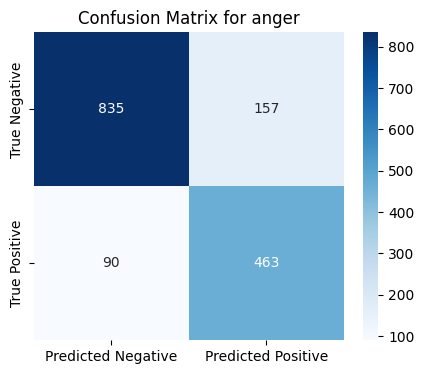

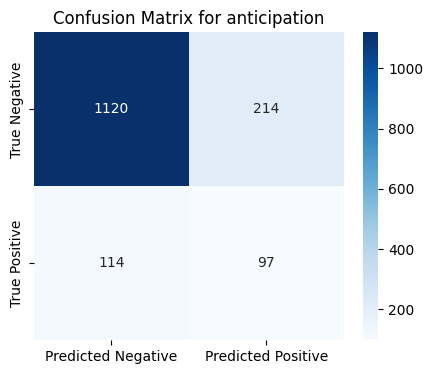

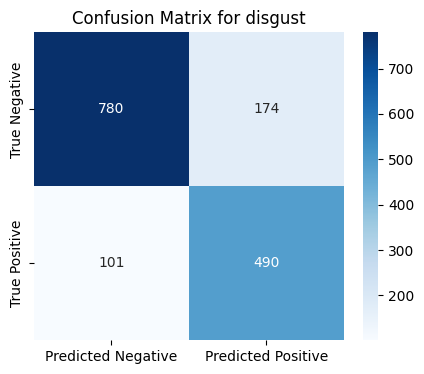

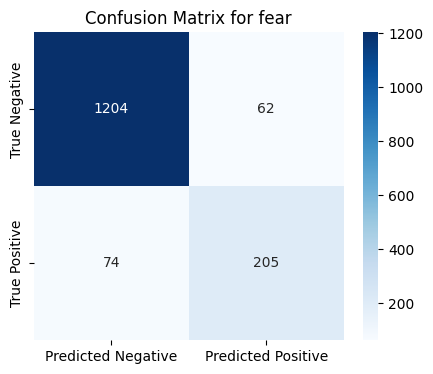

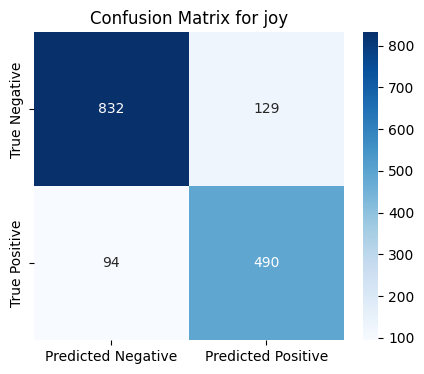

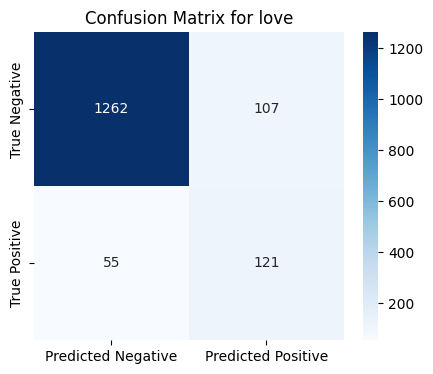

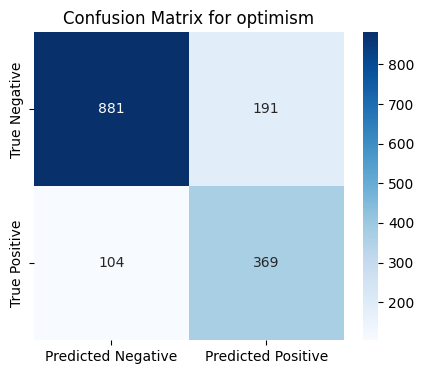

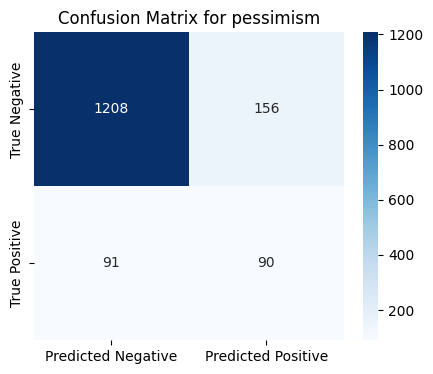

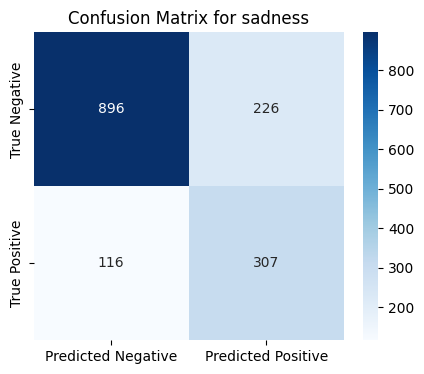

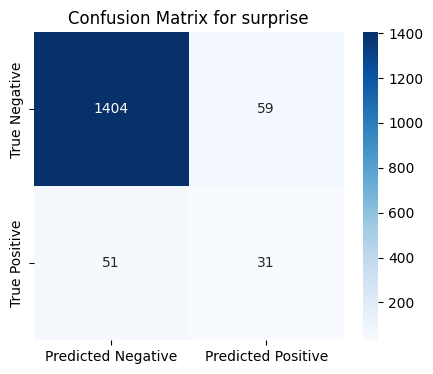

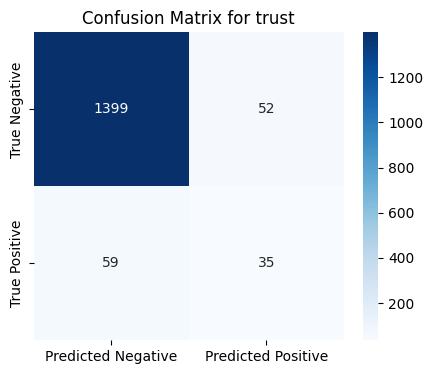

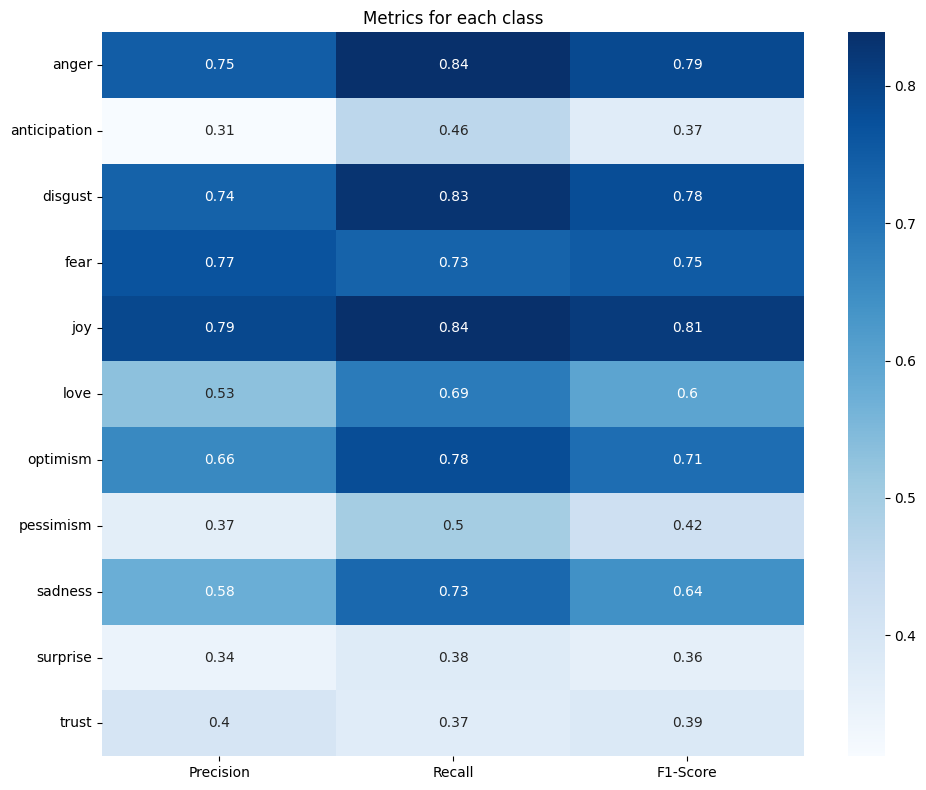

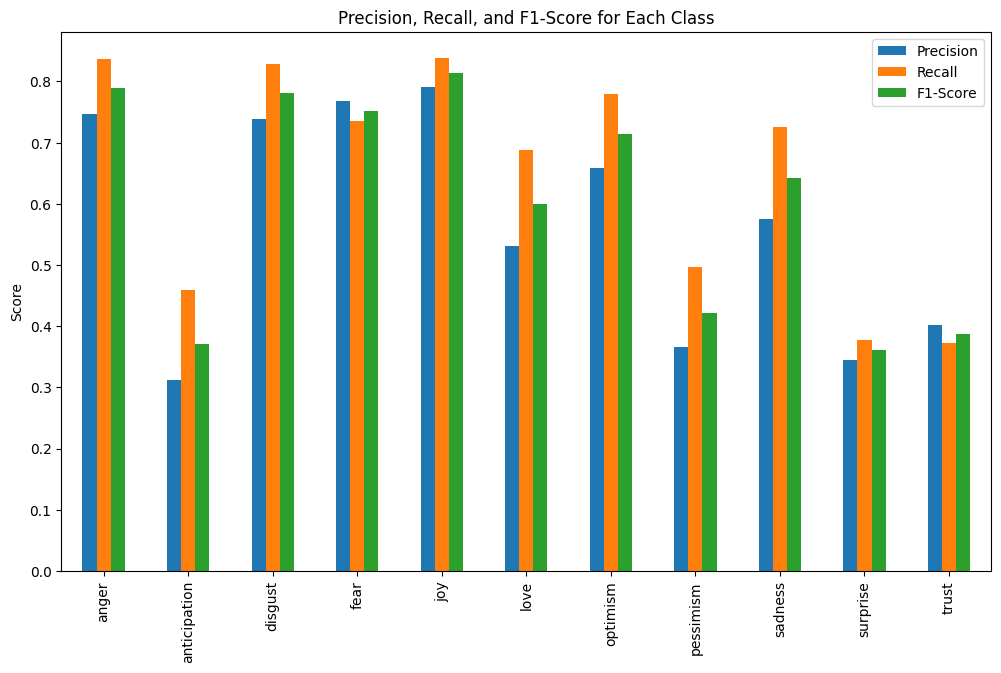

In [ ]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()

In [ ]:
wandb.finish()

eval/accuracy,▁▂▂▄▆▆▆▆▆▇█▇▇▇▇▆▇▇▇▇▇▇███
eval/f1_macro,▁▄▅▆▇▇███████████████████
eval/f1_micro,▁▅▆▆▇▇▇▇█████████████████
eval/loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▅▆█▃▄▁▂▁▁▂▅▁▂▄▅▃█▃▂▁▁▁▂▆▂
eval/samples_per_second,▃▃▁▆▄█▇█▇▇▃█▇▄▃▅▁▅▇▇▇▇▇▂▆
eval/steps_per_second,▃▃▁▆▄█▇█▇▇▃█▇▄▃▅▁▅▇▇▇▇▇▂▆
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


###  <font color = 'indianred'> **Save the model on HuggingFace**</font>

In [ ]:
#trainer.push_to_hub("yunase/Bert_QLoRA_emotion_detection")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/85.8M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yunaseo/emotions_bert_qlora/commit/feb15e9837119b807873e88379c6f8254582212f', commit_message='yunase/Bert_QLoRA_emotion_detection', commit_description='', oid='feb15e9837119b807873e88379c6f8254582212f', pr_url=None, pr_revision=None, pr_num=None)

## <Font color = 'indianred'>**3. Test Data Prediction** </font>

In [ ]:
# Make predictions
predictions = trainer.predict(tokenized_test_dataset["train"])

In [ ]:
# Post-processing for multi-label classification
threshold = 0.5  # Example threshold
predicted_labels = (predictions.predictions > threshold).astype(int)

# Convert predictions to labels
predicted_labels = [[label for label, binary in zip(labels, binary_labels) if binary] for binary_labels in predicted_labels]

# Print or use the predicted labels
print(predicted_labels)

[['anger', 'disgust', 'fear'], ['anger', 'disgust', 'sadness'], ['anger', 'disgust'], ['sadness'], ['fear', 'pessimism', 'sadness'], ['disgust', 'fear'], ['anticipation', 'optimism'], ['joy', 'love', 'optimism'], ['joy', 'optimism'], ['pessimism', 'sadness'], ['joy', 'optimism'], ['joy', 'optimism'], ['joy', 'love', 'optimism'], ['joy', 'optimism'], ['sadness'], ['joy', 'love', 'optimism'], ['anticipation', 'optimism'], ['joy', 'optimism'], ['anger', 'disgust'], ['pessimism', 'sadness'], ['joy', 'sadness'], ['sadness'], ['anticipation'], ['anticipation'], ['joy', 'love', 'optimism'], ['fear', 'sadness'], ['joy', 'love', 'optimism'], ['anticipation', 'joy'], ['anger', 'disgust'], ['anger', 'disgust'], ['joy', 'optimism', 'sadness'], ['disgust', 'sadness'], ['joy', 'optimism', 'sadness'], ['anger', 'disgust'], ['anger', 'disgust'], ['fear', 'sadness', 'surprise'], ['joy', 'surprise'], ['anger', 'disgust', 'pessimism', 'sadness'], ['anger', 'disgust'], ['anger', 'disgust'], ['anger', 'dis

In [ ]:
predicted_labels[0]

['anger', 'disgust', 'fear']

In [ ]:
test_data

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3259
    })
})

In [ ]:
# Extracting data from the 'train' split of test_data
test_data_train = test_data['train']
tweet_ids = test_data_train['ID']
num_tweets = len(tweet_ids)

In [ ]:
# Initializing an empty dictionary to store the predicted labels
predicted_labels_dict = {category: [0] * num_tweets for category in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']}

# Iterate over each row of predicted labels and update the dictionary
for i, labels in enumerate(predicted_labels):
    for label in labels:
        predicted_labels_dict[label][i] = 1

In [ ]:
# Create DataFrame
df = pd.DataFrame(predicted_labels_dict)

# Insert tweet IDs as the first column
df.insert(0, 'ID', tweet_ids)

In [ ]:
df

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,0,1,1,0,0,0,0,0,0,0
1,2018-03739,1,0,1,0,0,0,0,0,1,0,0
2,2018-00385,1,0,1,0,0,0,0,0,0,0,0
3,2018-03001,0,0,0,0,0,0,0,0,1,0,0
4,2018-01988,0,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,1,0,1,0,0,0,0,0,0,0,0
3255,2018-00416,0,1,0,1,0,0,0,0,0,0,0
3256,2018-03717,1,0,1,0,0,0,0,0,0,0,0
3257,2018-03504,0,0,0,0,1,1,1,0,0,0,0


In [ ]:
df.to_csv('bert_qlora_predicted.csv', index=False)

In [ ]:
from google.colab import files
files.download('bert_qlora_predicted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# <Font color = 'skyblue'>**Task 3 (optional) BERT** </font>

## <Font color = 'indianred'>**1. Load pre-trained Tokenizer** </font>

In [ ]:
# distilroberta-base
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [ ]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1545
    })
})

In [ ]:
tokenized_test_dataset = test_data_text.map(tokenize_fn, batched=True)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(
    ['text']
)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
tokenized_test_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3259
    })
})

##  <font color = 'indianred'> **2. Model Training**

###  <font color = 'indianred'> **2.1. compute_metrics function** </font>


In [ ]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

###  <font color = 'indianred'> **2.2. Training Arguments** </font>

In [ ]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_bert"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=10,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    # auto_find_batch_size=True,
    weight_decay=1.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=True,
)


### <Font color='indianred'> **2.3. Specify Model** <font/>

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification" )


config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config

# model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "trans

### <Font color='indianred'> **2.4. Custom Trainer**<font/>

In [ ]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)

In [ ]:
pos_weights

tensor([ 1.6795,  5.9349,  1.6519,  4.7002,  1.6947,  8.4192,  2.3988,  7.6541,
         2.3400, 18.6783, 19.1928])

In [ ]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [ ]:
pos_weights

tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # print(inputs)
        # Extract labels and remove them from inputs
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        # print(labels)
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        # Compute custom loss (BCEWithLogitsLoss is suitable for multi-label)
        # pos_weight can be used to handle class imbalance
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        # Reshape labels to match logits dimensions
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

### <font color='indianred'>**2.5 Setup WanDB**<font/>

In [ ]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_S2024

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=emotions_kaggle_S2024


### <font color = 'indianred'> **2.6 Start Training** <font/>

In [ ]:
trainer.train()  # start training

wandb: Currently logged in as: yuna-seo-95 (yunaseo_). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.754900,0.645534,0.612494,0.426408,0.124272
40,0.614400,0.567465,0.650994,0.518827,0.166990
60,0.549600,0.541377,0.674714,0.556978,0.188350
80,0.487800,0.519062,0.684946,0.589390,0.210356
100,0.475400,0.513981,0.680987,0.590862,0.201294
120,0.402700,0.516915,0.684854,0.587979,0.220712
140,0.398600,0.515113,0.688705,0.602367,0.192880
160,0.371100,0.518659,0.681986,0.599052,0.218770
180,0.325000,0.526265,0.675266,0.592824,0.194175
200,0.330300,0.529401,0.690038,0.594850,0.214887


TrainOutput(global_step=490, training_loss=0.306733678555002, metrics={'train_runtime': 295.6252, 'train_samples_per_second': 209.015, 'train_steps_per_second': 1.658, 'total_flos': 1684834167929592.0, 'train_loss': 0.306733678555002, 'epoch': 10.0})

### <font color='indianred'> **2.7 Validation**<font/>

In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.515113353729248,
 'eval_f1_micro': 0.6887052341597796,
 'eval_f1_macro': 0.6023674762678177,
 'eval_accuracy': 0.1928802588996764,
 'eval_runtime': 1.6794,
 'eval_samples_per_second': 919.994,
 'eval_steps_per_second': 7.741,
 'epoch': 10.0}

In [ ]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 140.


###  <font color = 'indianred'> **Check Confusion Matrix**</font>

In [ ]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [ ]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

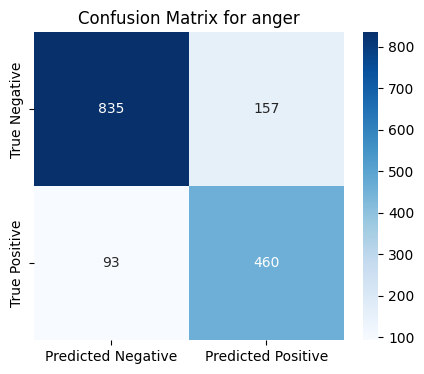

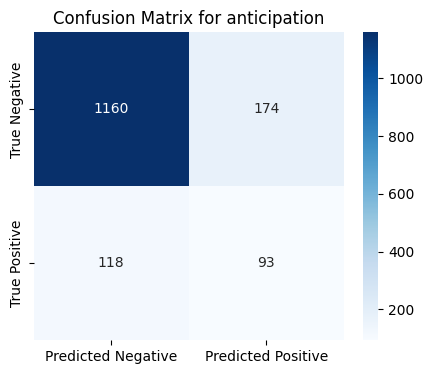

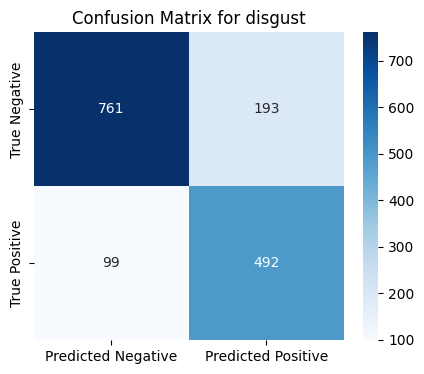

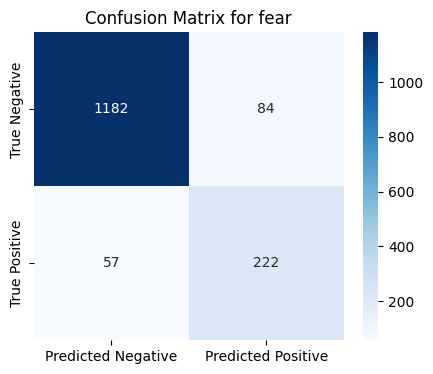

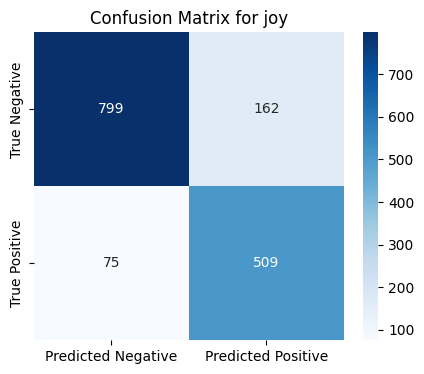

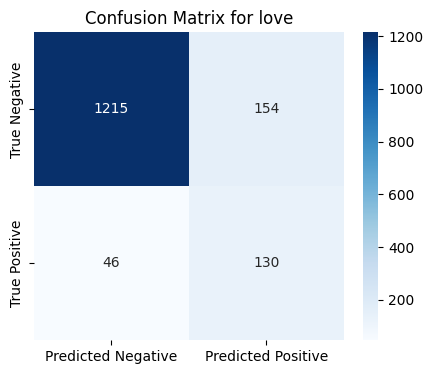

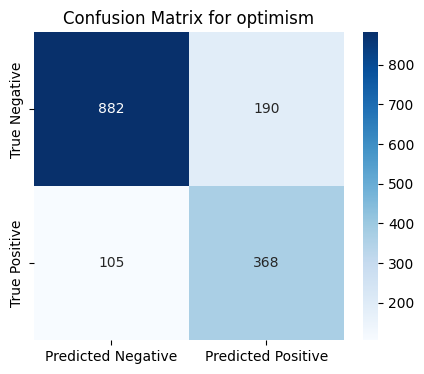

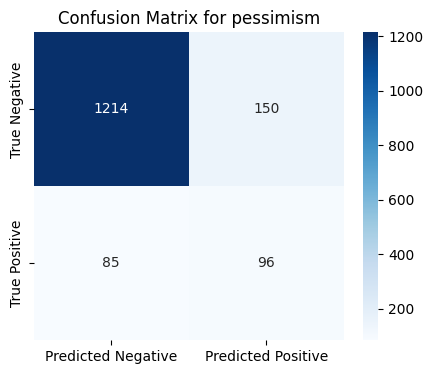

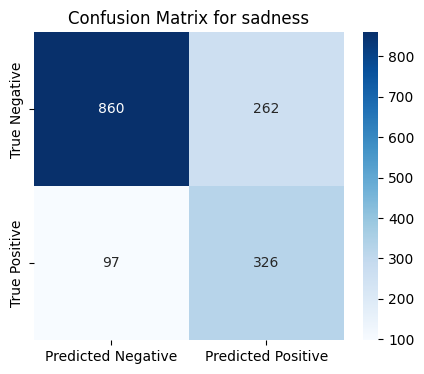

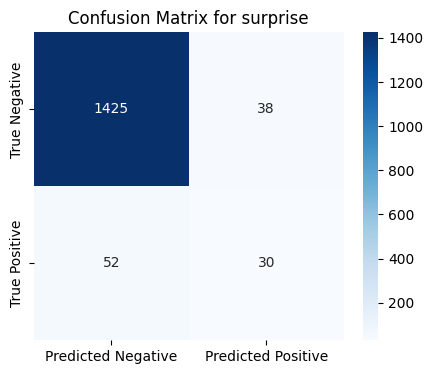

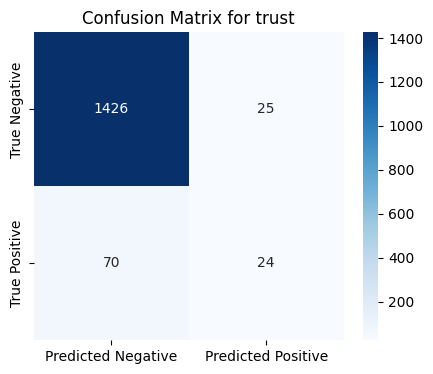

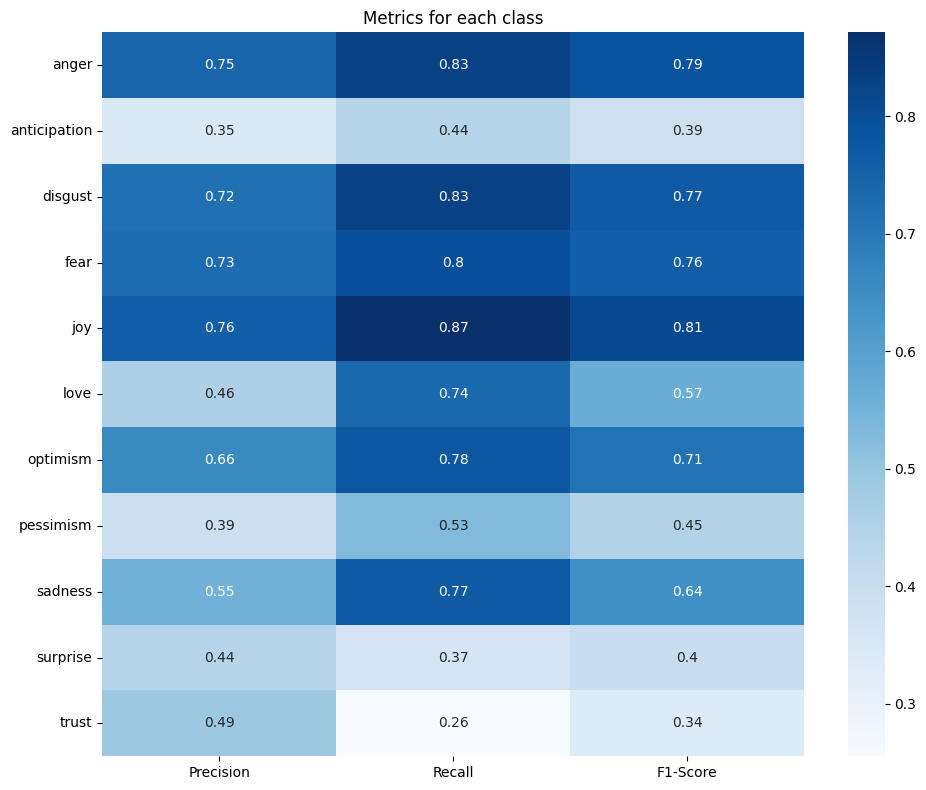

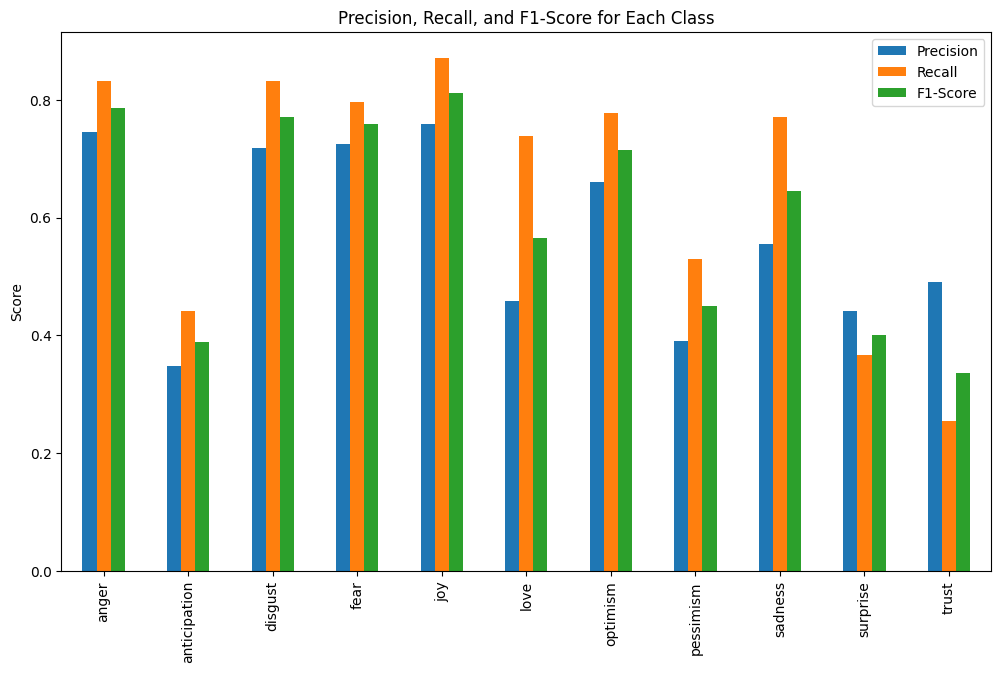

In [ ]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()

In [ ]:
wandb.finish()

eval/accuracy,▁▄▆▇▇█▆█▆█▇█▆▆█▇▇▇██▇▇██▆
eval/f1_macro,▁▅▆▇█▇█████▇▇▇▇▇▇▇▇▇▇▇▇▇█
eval/f1_micro,▁▄▇█▇██▇▇█▇▇▇▆▇▆▇▇▇▇▆▇▆▇█
eval/loss,▇▃▂▁▁▁▁▁▂▂▂▃▄▄▅▆▆▇▇▇▇███▁
eval/runtime,▂▁▃▄▃▃▃▃▂▄▄▃▃▁▂▃▃▂▃▅▆▂▄▂█
eval/samples_per_second,▇█▆▅▆▆▆▆▇▅▄▆▆▇▇▆▆▇▆▄▃▇▅▇▁
eval/steps_per_second,▇█▆▅▆▆▆▆▇▅▄▆▆▇▇▆▆▇▆▄▃▇▅▇▁
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


###  <font color = 'indianred'> **Save the model on HuggingFace**</font>

In [ ]:
trainer.push_to_hub("yunase/Bert_emotion_detection")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yunaseo/emotions_bert/commit/b265994cc58d5eac7440945172bb177224719c26', commit_message='yunase/Bert_emotion_detection', commit_description='', oid='b265994cc58d5eac7440945172bb177224719c26', pr_url=None, pr_revision=None, pr_num=None)

## <Font color = 'indianred'>**3. Test Data Prediction** </font>

In [ ]:
# Make predictions
predictions = trainer.predict(tokenized_test_dataset["train"])

In [ ]:
# Post-processing for multi-label classification
threshold = 0.5  # Example threshold
predicted_labels = (predictions.predictions > threshold).astype(int)

# Convert predictions to labels
predicted_labels = [[label for label, binary in zip(labels, binary_labels) if binary] for binary_labels in predicted_labels]

# Print or use the predicted labels
print(predicted_labels)

[['anger', 'disgust', 'fear'], ['anger', 'disgust', 'sadness'], ['anger', 'disgust'], ['joy', 'sadness'], ['anger', 'disgust', 'fear', 'pessimism', 'sadness'], ['anticipation', 'fear'], ['anticipation', 'joy', 'optimism'], ['joy', 'love', 'optimism'], ['joy', 'love', 'optimism'], ['pessimism', 'sadness'], ['joy', 'optimism'], ['joy', 'optimism'], ['joy', 'love', 'optimism'], ['joy', 'love', 'optimism'], ['sadness'], ['joy', 'love', 'optimism'], ['anticipation', 'joy'], ['joy', 'love', 'optimism'], ['anger', 'disgust', 'fear', 'sadness'], ['joy', 'sadness'], ['joy', 'love'], ['pessimism', 'sadness'], ['anticipation'], ['anticipation'], ['joy', 'love', 'optimism'], ['fear', 'sadness'], ['joy'], ['anticipation', 'joy'], ['anger', 'disgust'], ['anger', 'disgust'], ['joy', 'sadness'], ['anger', 'disgust', 'pessimism', 'sadness'], ['joy', 'optimism'], ['anger', 'disgust', 'sadness'], ['anger', 'disgust'], ['fear', 'sadness', 'surprise'], ['joy', 'surprise'], ['anger', 'disgust', 'pessimism',

In [ ]:
predicted_labels[0]

['anger', 'disgust', 'fear']

In [ ]:
test_data

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3259
    })
})

In [ ]:
# Extracting data from the 'train' split of test_data
test_data_train = test_data['train']
tweet_ids = test_data_train['ID']
num_tweets = len(tweet_ids)

In [ ]:
# Initializing an empty dictionary to store the predicted labels
predicted_labels_dict = {category: [0] * num_tweets for category in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']}

# Iterate over each row of predicted labels and update the dictionary
for i, labels in enumerate(predicted_labels):
    for label in labels:
        predicted_labels_dict[label][i] = 1

In [ ]:
# Create DataFrame
df = pd.DataFrame(predicted_labels_dict)

# Insert tweet IDs as the first column
df.insert(0, 'ID', tweet_ids)

In [ ]:
df

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,0,1,1,0,0,0,0,0,0,0
1,2018-03739,1,0,1,0,0,0,0,0,1,0,0
2,2018-00385,1,0,1,0,0,0,0,0,0,0,0
3,2018-03001,0,0,0,0,1,0,0,0,1,0,0
4,2018-01988,1,0,1,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,1,0,1,0,0,0,0,0,0,0,0
3255,2018-00416,0,1,0,1,1,0,0,0,0,0,0
3256,2018-03717,1,0,1,0,0,0,0,0,0,0,0
3257,2018-03504,0,0,0,0,1,1,1,0,0,0,0


In [ ]:
df.to_csv('bert_predicted.csv', index=False)

In [ ]:
from google.colab import files
files.download('bert_predicted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>